# Run "ETL" script

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/22 11:20:56 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.25.232.62 instead (on interface eth0)
22/09/22 11:20:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/22 11:20:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/22 11:21:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample.unionByName(transactions_sample2, True)
transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [3]:
merchants = merchants_tbl.toPandas()

In [4]:
import re
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [5]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [6]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [7]:
# This could be further expanded in breaking the discription up further

In [8]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [9]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [10]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

# Examine 5% drop of dataset

In [11]:
# First lets look at the number of registered customers and merchants without any data in the dataset
full_dataset.createOrReplaceTempView('full')
merchants_tbl.createOrReplaceTempView('merchants')
customer_tbl.createOrReplaceTempView('consumer')
transactions_sample.createOrReplaceTempView('trans')
missing = spark.sql("""
select count(*) from trans
where trans.merchant_abn not in (select merchant_abn from merchants)
""")
#full_dataset.count()

From above, we can see that 100% of the dropped transactions are due to a mis-match of the merchant abn numbers. In this case, there is no use for these transactions. However, in the future, these rows could be still used in relation to the customers history, escpecailly in the essence of labeling 'consistent spender',...

# In-Depth Analysis of Dollar_Value and BNPL_Revenue attributes

In [12]:
full_dataset.createOrReplaceTempView('full_dat')
user_data = spark.sql("""
select user_id, min(dollar_value) as min, max(dollar_value) as max, mean(dollar_value) as mean, 
percentile_approx(dollar_value, 0.5) as median, std(dollar_value) as std, count(*) as count from full_dat
where dollar_value > 1
group by user_id
""")
merchant_agg = spark.sql("""
select merchant_abn,Earnings_Class, min(dollar_value) as min, max(dollar_value) as max, mean(dollar_value) as mean, 
percentile_approx(dollar_value, 0.5) as median, std(dollar_value) as std, count(*) as count from full_dat
where dollar_value > 1
group by merchant_abn, Earnings_Class
""")

In [13]:
user_data = user_data.toPandas()
merchant_agg = merchant_agg.toPandas()

In [14]:
user_data

,user_id,min,max,mean,median,std,count
0,7,3.679791,2164.264106,178.418259,69.874567,311.574164,188
1,19,1.700273,2809.102513,147.768017,59.454107,280.122487,194
2,22,1.187602,2272.177699,138.779028,68.397592,251.832376,189
3,26,2.243676,1975.690954,157.680642,63.767430,258.912357,165
4,29,2.869569,4659.105369,181.617546,61.767543,443.021771,173
...,...,...,...,...,...,...,...
24076,23767,1.532057,1897.591966,135.775372,61.239438,214.888246,195
24077,23776,2.833877,2016.837980,139.726709,72.711457,239.017544,170
24078,23844,1.675655,5570.186332,162.907211,55.937752,470.293536,167
24079,23931,1.033464,1315.469573,138.404347,77.957924,176.755682,171


<AxesSubplot:xlabel='count', ylabel='Count'>

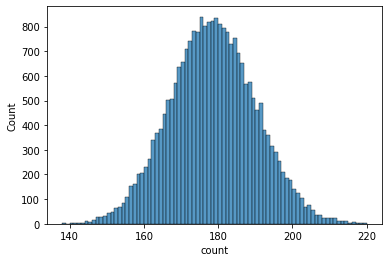

In [15]:
import seaborn as sns
sns.histplot(x='count', data = user_data, binwidth=1)
# The individual_count is rather interesting (especially with the > 5 < 2000 cap)

In [16]:
user_data[user_data['max'] > 5000].sort_values(by=['std'])

,user_id,min,max,mean,median,std,count
9637,5299,1.376058,5079.128902,140.417785,53.452808,391.533076,193
6027,253,2.903626,5053.316415,149.067428,63.386164,393.532855,197
7958,16031,1.565361,5078.294780,156.805071,60.902284,395.665577,199
10902,15542,2.432008,5000.793776,141.821777,58.061866,397.901317,178
10234,9992,1.203192,5019.995669,142.310330,69.676279,400.146438,180
...,...,...,...,...,...,...,...
19736,15790,1.166995,47538.554826,486.753377,59.945041,3583.705897,193
9716,5965,1.783943,43965.463557,508.297763,64.678195,3625.738646,173
3750,6383,1.049040,46001.139019,542.433417,61.588424,3760.727332,177
3976,8117,1.919587,39316.688056,561.400052,67.151432,3884.045697,183


<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

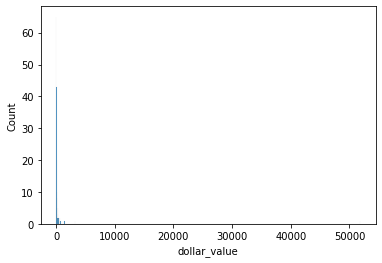

In [17]:
# lets examine the distribution of the mode
sns.histplot(x = 'dollar_value',data = full_dataset.where(full_dataset.user_id == 22239).select('dollar_value').toPandas())

In [18]:
# For merchant ID

In [19]:
merchant_agg[(merchant_agg['count'] > 10)].sort_values(by=['std'], ascending=False)

,merchant_abn,Earnings_Class,min,max,mean,median,std,count
471,11149063370,b,2016.978978,47346.113374,17418.653923,15930.678944,12403.874225,29
3731,83199298021,b,3149.397664,47538.554826,17928.460231,13701.303253,11152.015889,64
1090,35575706403,b,447.608928,50209.505439,11518.072706,8090.569703,10753.975055,24
3761,91880575299,b,3507.708173,38351.181004,17387.724074,16464.936870,10708.537062,11
938,97884414539,a,1076.657304,44615.022521,10902.952330,7541.723847,10619.186146,17
...,...,...,...,...,...,...,...,...
2653,38361767065,b,157.000000,157.000000,157.000000,157.000000,0.000000,50
3648,65345485504,b,157.000000,157.000000,157.000000,157.000000,0.000000,27
3651,66571984047,b,157.000000,157.000000,157.000000,157.000000,0.000000,1584
30,14804580099,a,157.000000,157.000000,157.000000,157.000000,0.000000,449


<AxesSubplot:xlabel='dollar_value'>

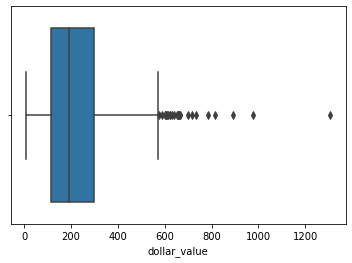

In [20]:
sns.boxplot(x='dollar_value', data=full_dataset.where(full_dataset.merchant_abn == 10023283211).select('dollar_value').toPandas())

<AxesSubplot:xlabel='std', ylabel='Count'>

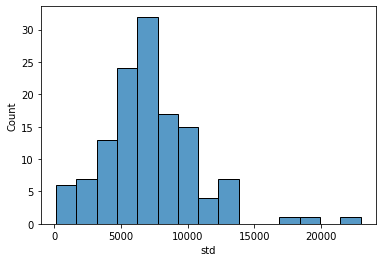

In [21]:
import seaborn as sns
sns.histplot(x='std', data = merchant_agg[merchant_agg['mean'] > 5000])


# Outlier detection algorithm
This will be inplemented by taking the 95% CI from the mean, and removing values which fall out of this coverage (more explanation below)

In [22]:
# First we need to collect each unique merchant, and store in a variable
# from above
merchants.drop('tags', axis=1, inplace=True)


In [23]:
# Due to the dat being skewed, instead of using the IQR range, the Medcouples method see below, to account for skewness
    # link:https://towardsdatascience.com/outlier-detection-part-2-6839f6199768Thrd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'))
quartile_dataset = quartile_dataset.withColumn('IQR', F.col('3_val') - F.col('1_val'))
# can manupulate the upper value to meet the skew in the graph
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 1.5 * F.col('IQR'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 1.5 * F.col('IQR'))
quartile_dataset = quartile_dataset.select('merchant_abn', 'IQR', 'Upper_limit', 'Lower_limit')

In [24]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [25]:
# finally identify the outliers
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')), False)
                                              .otherwise(True))

In [26]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

141180

In [27]:
# About 3% of the dataset is identified as outliers. Although there is a chance that some entities have been missclassified

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

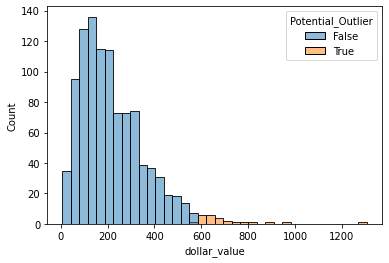

In [28]:
sns.histplot(x='dollar_value', hue = 'Potential_Outlier', data=full_quantile.where(full_quantile.merchant_abn == 10023283211).select('dollar_value', 'Potential_Outlier').toPandas())